# **Supplementary materials**: From pencil to pixel: assessing Ceramatic 2.0 against manual and laser-aided techniques in archaeological pottery documentation

## Morphological analysis

In [6]:
# Importing required libries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from utils import read_img_files, minimum_image, denoise_and_binarize, dice_coefficient, rotate_image, optimize_rotation


from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform

In [2]:
# Importing excel data

df = pd.read_excel("MORPHO/file_list.xlsx")

In [3]:
df.head()

,File,Method,Record
0,CER_1350.jpg,CER,1350
1,CER_1351.jpg,CER,1351
2,CER_1352.jpg,CER,1352
3,CER_1353.jpg,CER,1353
4,CER_1354.jpg,CER,1354


In [4]:
# Process images 

imgs_dims = []
imgs_arr = []
min_imgs = []

for img in read_img_files("MORPHO"):
    img = Image.open(img)
    img_arr = np.array(img)
    img_arr = 1 - img_arr / 255
    img_arr = denoise_and_binarize(img_arr)
    img_arr = minimum_image(img_arr).astype(np.int8)
    min_imgs.append(img_arr)
    img_dims = img_arr.shape
    imgs_dims.append(img_dims)
    imgs_arr.append(img_arr)

imgs_dims = np.array(imgs_dims)

max_imgs = np.max(imgs_dims, axis=0)

empty_array = np.zeros((len(imgs_dims), max_imgs[0], max_imgs[1]))



for i, img in enumerate(imgs_arr):
    empty_array[i, :img.shape[0], :img.shape[1]] = img

something strange happened for file file_list.xlsx


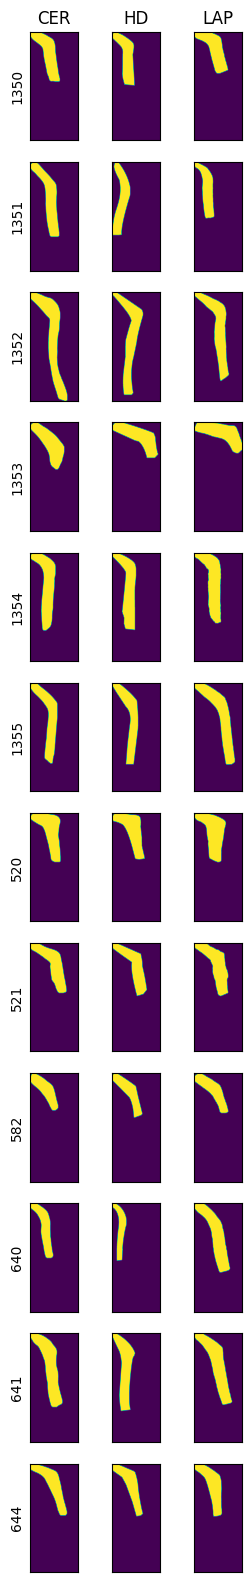

In [5]:
# Create a grid of images for each different pot

fig, ax = plt.subplots(len(df.Record.unique()), 3, figsize=(3, 20))

for i, item in enumerate(df.Record.unique()):
    selected_df = df[df.Record == item]

    for j, (index, row) in enumerate(selected_df.iterrows()):
        img = empty_array[index]
        ax[i, j].imshow(img, cmap='viridis')

        ax[i, 0].set_ylabel(row["Record"])

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

    ### add title
    ax[0, 0].set_title(f"CER")
    ax[0, 1].set_title(f"HD")
    ax[0, 2].set_title(f"LAP")

In [16]:
# Perform dice coefficient calculation

res_matrix = []

for i, item in enumerate(df.Record.unique()):
    selected_df = df[df.Record == item]

    res = squareform(pdist(empty_array[selected_df.index].reshape(len(selected_df.index), -1), metric='dice'))

    res_matrix.append(res)

res_matrix = np.array(res_matrix)

In [17]:
# Get a correlation matrix

total_correlation_matrix = pd.DataFrame(np.median(res_matrix, axis=0), columns=["CER", "HD", "LAP"], index=["CER", "HD", "LAP"])

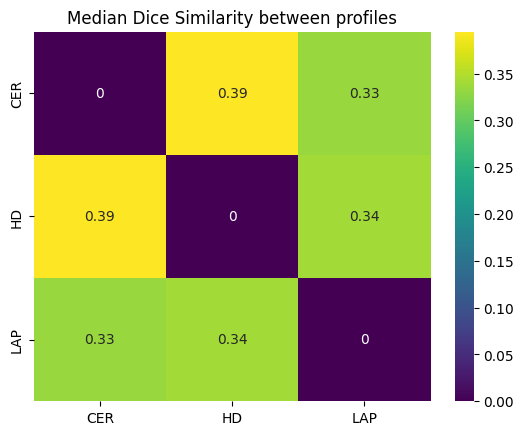

In [18]:
sns.heatmap(total_correlation_matrix, cmap='viridis', annot=True)

plt.title("Median Dice Similarity between profiles")

### save imgs 
plt.savefig("dice_similarity.jpg", dpi=300, bbox_inches='tight')

In [19]:
# Save each distance in a vector

cer_hd = res_matrix[:, 1, 0]
cer_lap = res_matrix[:, 2, 0]
hd_lap = res_matrix[:, 2, 1]

## Orientation analysis

In [20]:
# Calcolate orientation angle

imgs_size = [x.shape for x in min_imgs]

df["cathetus_1"] = [x[0] for x in imgs_size]
df["cathetus_2"] = [x[1] for x in imgs_size]

df["tan"] = df.cathetus_1 / df.cathetus_2

df["angle"] = np.arctan(df.tan) * 180 / np.pi

In [21]:
# Calculate the correlation matrix

res_matrix = []

for i, item in enumerate(df.Record.unique()):
    selected_df = df[df.Record == item]

    res = squareform(pdist(selected_df["angle"].values.reshape(-1, 1), metric='euclidean'))

    res_matrix.append(res)

res_matrix = np.array(res_matrix)

In [22]:
total_correlation_matrix = pd.DataFrame(np.median(res_matrix, axis=0), columns=["CER", "HD", "LAP"], index=["CER", "HD", "LAP"])

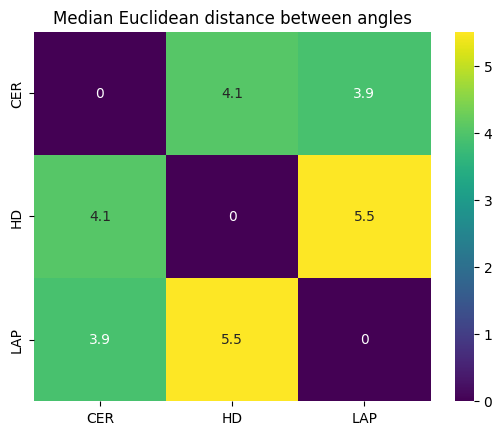

In [23]:
sns.heatmap(total_correlation_matrix, cmap='viridis', annot=True)

plt.title("Median Euclidean distance between angles")

### save imgs
plt.savefig("angle_distance.jpg", dpi=300, bbox_inches='tight')

In [26]:
# Save each distance in a vector
cer_hd_angle = res_matrix[:, 1, 0]
cer_lap_angle = res_matrix[:, 2, 0]
hd_lap_angle = res_matrix[:, 2, 1]


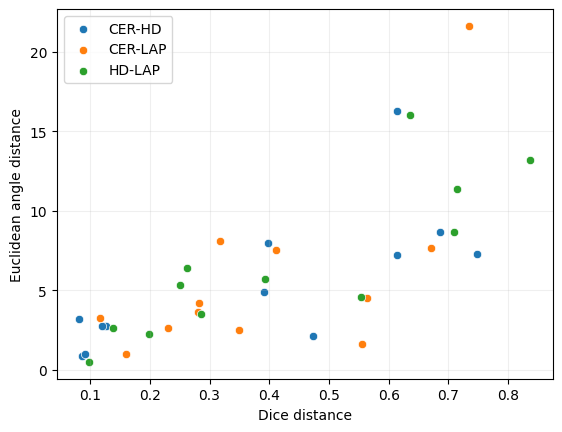

In [27]:
# Visualise correlation

sns.scatterplot(x = cer_hd,  y = cer_hd_angle, label="CER-HD")
sns.scatterplot(x = cer_lap, y = cer_lap_angle, label="CER-LAP")
sns.scatterplot(x = hd_lap, y = hd_lap_angle, label="HD-LAP")

plt.legend()

plt.xlabel("Dice distance")
plt.ylabel("Euclidean angle distance")

### add grid

plt.grid(alpha=0.2)

### save imgs
plt.savefig("angle_dice_distance.jpg", dpi=300, bbox_inches='tight')

In [28]:
# Calculate the correlation between the distances

correlations = []

for x, y in zip([cer_hd, cer_lap, hd_lap], [cer_hd_angle, cer_lap_angle, hd_lap_angle]):
    corr, p = spearmanr(x, y)
    correlations.append((corr, p))

correlations_df = pd.DataFrame(correlations, columns=["Correlation", "p-value"], index=["CER-HD", "CER-LAP", "HD-LAP"])


In [29]:
#| echo: false

correlations_df.round(2)

,Correlation,p-value
CER-HD,0.73,0.01
CER-LAP,0.57,0.05
HD-LAP,0.86,0.00


## Morphological analysis (pt. 2)

In [30]:
# Pad the images

padded_array = []

for i, elem in enumerate(empty_array):
    padded_array.append(np.pad(empty_array[i], ((0, 0), (empty_array[i].shape[1], 0)), mode='constant'))

padded_array = np.array(padded_array)

In [31]:
#| Define a pivot point

for i, item in enumerate(df.Record.unique()):
    selected_df = df[df.Record == item]

    selected_array = padded_array[selected_df.index]

pivot_point = (padded_array.shape[2] // 2, 0)

In [32]:
# Optimize rotation for image2 and image3 to align with image1
optimal_angle2 = optimize_rotation(selected_array[0], selected_array[1], pivot_point)
optimal_angle3 = optimize_rotation(selected_array[0], selected_array[2], pivot_point)

In [33]:
# Rotate the images with optimal angles
rotated_image2 = rotate_image(selected_array[1], optimal_angle2, pivot_point)
rotated_image3 = rotate_image(selected_array[2], optimal_angle3, pivot_point)

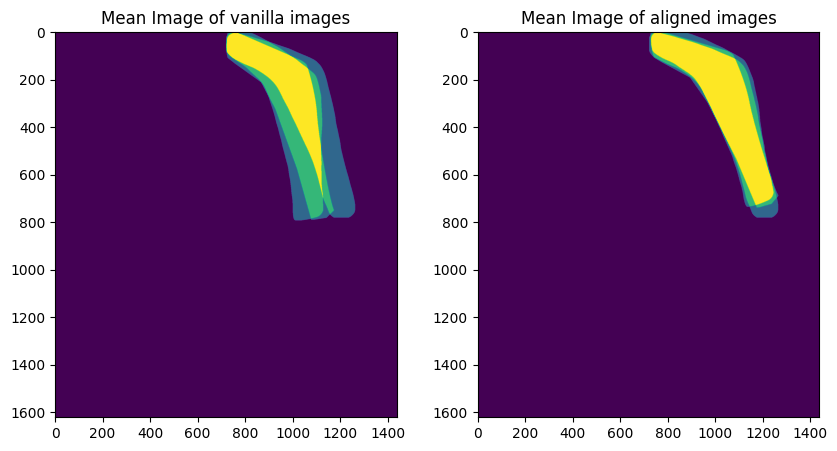

In [34]:
# Plot the images to check the alignment

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.mean(selected_array, axis=0), cmap='viridis')
ax[0].set_title('Mean Image of vanilla images')

ax[1].imshow(np.mean([selected_array[0], rotated_image2, rotated_image3], axis=0), cmap='viridis')
ax[1].set_title('Mean Image of aligned images');

### save imgs
plt.savefig("mean_image.jpg", dpi=300, bbox_inches='tight')

In [35]:
# Allign the images

res_matrix = []

for i, item in enumerate(df.Record.unique()):
    selected_df = df[df.Record == item]

    selected_array = padded_array[selected_df.index]

    # Optimize rotation for image2 and image3 to align with image1
    optimal_angle2 = optimize_rotation(selected_array[0], selected_array[1], pivot_point)
    optimal_angle3 = optimize_rotation(selected_array[0], selected_array[2], pivot_point)

    # Rotate the images with optimal angles
    rotated_image2 = rotate_image(selected_array[1], optimal_angle2, pivot_point)
    rotated_image3 = rotate_image(selected_array[2], optimal_angle3, pivot_point)

    ### stuck the images together

    stacked_images = np.stack((selected_array[0], rotated_image2, rotated_image3))

    res = squareform(pdist(stacked_images.reshape(len(selected_df.index), -1), metric='dice'))

    res_matrix.append(res)

res_matrix = np.array(res_matrix)

In [36]:
total_matrix_aligned = pd.DataFrame(np.median(res_matrix, axis=0), columns=["CER", "HD", "LAP"], index=["CER", "HD", "LAP"])

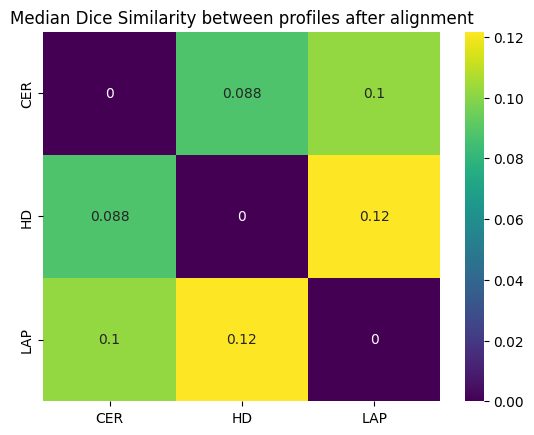

In [37]:
sns.heatmap(total_matrix_aligned, cmap='viridis', annot=True)

### add title
plt.title("Median Dice Similarity between profiles after alignment")

### save imgs
plt.savefig("dice_similarity_aligned.jpg", dpi=300, bbox_inches='tight')

In [39]:
# Save each distance in a vector

cer_hd_aligned = res_matrix[:, 1, 0]
cer_lap_aligned = res_matrix[:, 2, 0]
hd_lap_aligned = res_matrix[:, 2, 1]

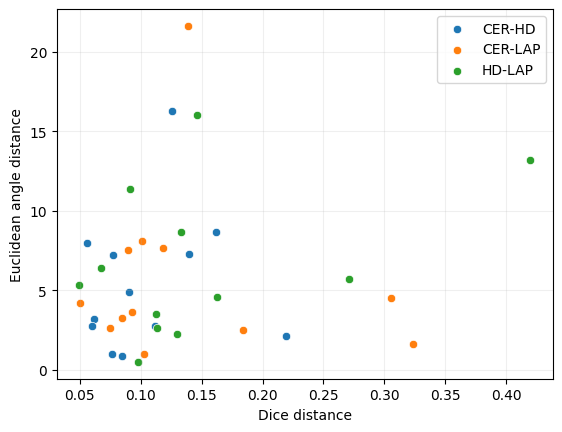

In [40]:
# Check the correlation between the distances


sns.scatterplot(x = cer_hd_aligned,  y = cer_hd_angle, label="CER-HD")
sns.scatterplot(x = cer_lap_aligned, y = cer_lap_angle, label="CER-LAP")
sns.scatterplot(x = hd_lap_aligned, y = hd_lap_angle, label="HD-LAP")

plt.legend()

plt.xlabel("Dice distance")
plt.ylabel("Euclidean angle distance")

### add grid

plt.grid(alpha=0.2)

### save imgs
plt.savefig("angle_dice_distance_aligned.jpg", dpi=300, bbox_inches='tight')

In [41]:
correlations = []

for x, y in zip([cer_hd_aligned, cer_lap_aligned, hd_lap_aligned], [cer_hd_angle, cer_lap_angle, hd_lap_angle]):
    corr, p = spearmanr(x, y)
    correlations.append((corr, p))

correlations_df = pd.DataFrame(correlations, columns=["Correlation", "p-value"], index=["CER-HD", "CER-LAP", "HD-LAP"])

correlations_df


,Correlation,p-value
CER-HD,0.146853,0.648796
CER-LAP,-0.055944,0.862898
HD-LAP,0.279720,0.378569


## Diameter analysis

In [42]:
# Load the measures

df_diameter = pd.read_excel("measures.xlsx")

In [43]:
# Remove the NaN values

df_diameter.dropna(inplace=True)

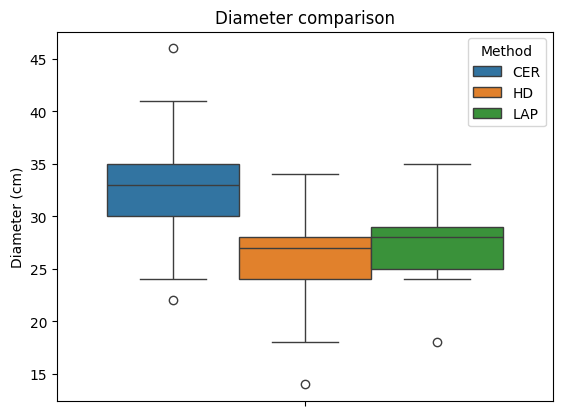

In [45]:
# Boxplots for data comparison

sns.boxplot(data=df_diameter, y="DIAM", hue="Method")

## x axis label

plt.ylabel("Diameter (cm)")

### add title
plt.title("Diameter comparison")

### save imgs
plt.savefig("diameter_comparison.jpg", dpi=300, bbox_inches='tight')